In [44]:
using AbstractGPs, Plots
using Distributions;

In [12]:
?rand

search: rand randn rand! transcode @shorthands macroexpand @macroexpand



```
rand([rng=GLOBAL_RNG], [S], [dims...])
```

Pick a random element or array of random elements from the set of values specified by `S`; `S` can be

  * an indexable collection (for example `1:9` or `('x', "y", :z)`),
  * an `AbstractDict` or `AbstractSet` object,
  * a string (considered as a collection of characters), or
  * a type: the set of values to pick from is then equivalent to `typemin(S):typemax(S)` for integers (this is not applicable to [`BigInt`](@ref)), to $[0, 1)$ for floating point numbers and to $[0, 1)+i[0, 1)$ for complex floating point numbers;

`S` defaults to [`Float64`](@ref). When only one argument is passed besides the optional `rng` and is a `Tuple`, it is interpreted as a collection of values (`S`) and not as `dims`.

!!! compat "Julia 1.1"
    Support for `S` as a tuple requires at least Julia 1.1.


# Examples

```julia-repl
julia> rand(Int, 2)
2-element Array{Int64,1}:
 1339893410598768192
 1575814717733606317

julia> using Random

julia> rand(MersenneTwister(0), Dict(1=>2, 3=>4))
1=>2

julia> rand((2, 3))
3

julia> rand(Float64, (2, 3))
2×3 Array{Float64,2}:
 0.999717  0.0143835  0.540787
 0.696556  0.783855   0.938235
```

!!! note
    The complexity of `rand(rng, s::Union{AbstractDict,AbstractSet})` is linear in the length of `s`, unless an optimized method with constant complexity is available, which is the case for `Dict`, `Set` and dense `BitSet`s. For more than a few calls, use `rand(rng, collect(s))` instead, or either `rand(rng, Dict(s))` or `rand(rng, Set(s))` as appropriate.


---

```
rand([rng::AbstractRNG,] s::Sampleable)
```

Generate one sample for `s`.

```
rand([rng::AbstractRNG,] s::Sampleable, n::Int)
```

Generate `n` samples from `s`. The form of the returned object depends on the variate form of `s`:

  * When `s` is univariate, it returns a vector of length `n`.
  * When `s` is multivariate, it returns a matrix with `n` columns.
  * When `s` is matrix-variate, it returns an array, where each element is a sample matrix.

    rand([rng::AbstractRNG,] s::Sampleable, dim1::Int, dim2::Int...)   rand([rng::AbstractRNG,] s::Sampleable, dims::Dims)

Generate an array of samples from `s` whose shape is determined by the given dimensions.

---

```
rand(rng::AbstractRNG, d::UnivariateDistribution)
```

Generate a scalar sample from `d`. The general fallback is `quantile(d, rand())`.

---

```
rand(rng, d)
```

Extract a sample from the p-Generalized Gaussian distribution 'd'. The sampling procedure is implemented from from [1]. [1]  Gonzalez-Farias, G., Molina, J. A. D., & Rodríguez-Dagnino, R. M. (2009). Efficiency of the approximated shape parameter estimator in the generalized Gaussian distribution. IEEE Transactions on Vehicular Technology, 58(8), 4214-4223.

---

```
rand(::AbstractRNG, ::Distributions.AbstractMvNormal)
```

Sample a random vector from the provided multi-variate normal distribution.

---

```
rand(::AbstractRNG, ::Sampleable)
```

Samples from the sampler and returns the result.

---

```
rand(d::Union{UnivariateMixture, MultivariateMixture})
```

Draw a sample from the mixture model `d`.

```
rand(d::Union{UnivariateMixture, MultivariateMixture}, n)
```

Draw `n` samples from `d`.

---

```
rand(rng::AbstractRNG, f::FiniteGP, N::Int=1)
```

Obtain `N` independent samples from the marginals `f` using `rng`. Single-sample methods produce a `length(f)` vector. Multi-sample methods produce a `length(f)` × `N` `Matrix`.

```jldoctest
julia> f = GP(Matern32Kernel());

julia> x = randn(11);

julia> rand(f(x)) isa Vector{Float64}
true

julia> rand(MersenneTwister(123456), f(x)) isa Vector{Float64}
true

julia> rand(f(x), 3) isa Matrix{Float64}
true

julia> rand(MersenneTwister(123456), f(x), 3) isa Matrix{Float64}
true
```


In [37]:
# Generate toy synthetic data.
x = rand(Uniform(0,10.0), 50)
y = sin.(x)

# Define GP prior with Matern-3/2 kernel
f = GP(Matern32Kernel())

# Finite projection of `f` at inputs `x`.
# Added Gaussian noise with variance 0.001.
fx = f(x, 0.01)

# Log marginal probability of `y` under `f` at `x`.
# Quantity typically maximised to train hyperparameters.
logpdf(fx, y)

17.223284913775142

In [38]:
f

GP{AbstractGPs.ZeroMean{Float64}, Matern32Kernel{Distances.Euclidean}}(AbstractGPs.ZeroMean{Float64}(), Matern 3/2 Kernel (metric = Distances.Euclidean(0.0)))

In [39]:
fx

AbstractGPs.FiniteGP{GP{AbstractGPs.ZeroMean{Float64}, Matern32Kernel{Distances.Euclidean}}, Vector{Float64}, LinearAlgebra.Diagonal{Float64, FillArrays.Fill{Float64, 1, Tuple{Base.OneTo{Int64}}}}}(
f: GP{AbstractGPs.ZeroMean{Float64}, Matern32Kernel{Distances.Euclidean}}(AbstractGPs.ZeroMean{Float64}(), Matern 3/2 Kernel (metric = Distances.Euclidean(0.0)))
x: [3.313355613217027, 0.1564444711874824, 2.109868180042688, 1.8877851813503366, 9.858244246611394, 9.39841727535571, 6.284523339575029, 1.2890116061737455, 2.998354933003986, 1.1265328228068427  …  6.068990203612193, 3.367942905128347, 0.41286855350007867, 2.1731963806245105, 5.247483647442126, 5.732685691753998, 7.594447380562583, 4.62138981045031, 3.3398518247511455, 7.171128353028421]
Σy: [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01]
)


In [40]:
# Exact posterior given `y`. This is another GP.
p_fx = posterior(fx, y)

# Log marginal posterior predictive probability.
logpdf(p_fx(x), y)

102.48599641538036

In [41]:
p_fx

AbstractGPs.PosteriorGP{GP{AbstractGPs.ZeroMean{Float64}, Matern32Kernel{Distances.Euclidean}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, Vector{Float64}, Vector{Float64}}}}(GP{AbstractGPs.ZeroMean{Float64}, Matern32Kernel{Distances.Euclidean}}(AbstractGPs.ZeroMean{Float64}(), Matern 3/2 Kernel (metric = Distances.Euclidean(0.0))), (α = [-0.019610097438551098, -0.87356760169729, 0.057187573404512124, 0.10260614495206917, -0.24619629778157764, -0.03144757859967867, 0.0028722192256237116, 0.09923282085889214, 0.0418006102286899, 0.27068166322954806  …  -0.016744045218828944, -0.07310108715818261, 0.2267687962672331, 0.038351811308593386, -0.10419932659257221, -0.143418600987784, 0.1414907232367616, -0.1073398016338173, -0.04099496010839488, 0.26083647264420123], C = LinearAlgebra.Cholesky{Float64, Matrix{Float64}}([1.004987562112089 0.027158927561138704 … 0.9940208566313966 0.009581011968155858; 0.027294384399247605 1.0046205217

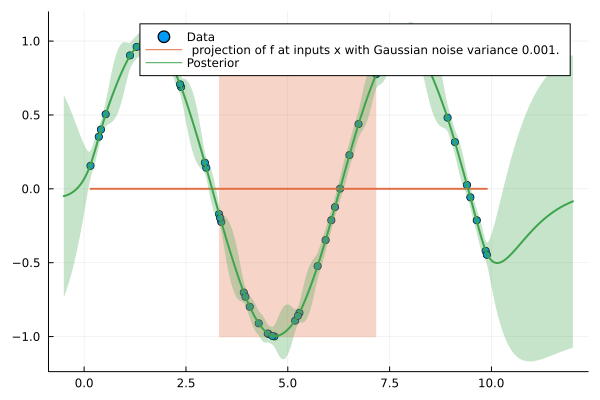

In [42]:
# Plot posterior.
scatter(x, y; label="Data")
plot!(x, fx; label=" projection of f at inputs x with Gaussian noise variance 0.001.")
plot!(-0.5:0.001:12, p_fx; label="Posterior")

  0.000806 seconds (424 allocations: 47.227 KiB)


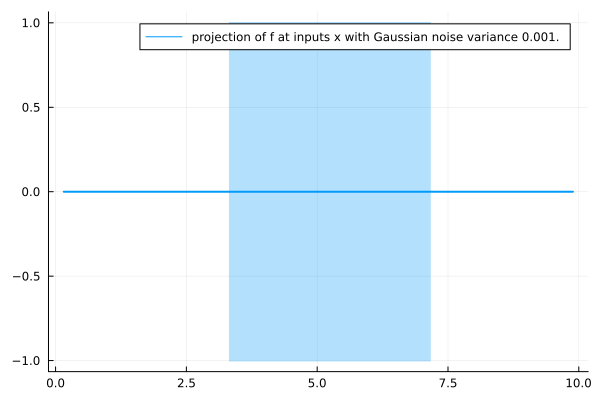

In [43]:
@time plot(x, fx; label=" projection of f at inputs x with Gaussian noise variance 0.001.")

In [11]:
?logpdf

search: logpdf



```
logpdf(d::Distribution{ArrayLikeVariate{N}}, x::AbstractArray{<:Real,N}) where {N}
```

Evaluate the probability density function of `d` at `x`.

This function checks if the size of `x` is compatible with distribution `d`. This check can be disabled by using `@inbounds`.

# Implementation

Instead of `logpdf` one should implement `_logpdf(d, x)` which does not have to check the size of `x`.

See also: [`pdf`](@ref).

---

```
logpdf(d::Distribution{ArrayLikeVariate{N}}, x) where {N}
```

Evaluate the logarithm of the probability density function of `d` at every element in a collection `x`.

This function checks for every element of `x` if its size is compatible with distribution `d`. This check can be disabled by using `@inbounds`.

Here, `x` can be

  * an array of dimension `> N` with `size(x)[1:N] == size(d)`, or
  * an array of arrays `xi` of dimension `N` with `size(xi) == size(d)`.

---

```
logpdf(d::UnivariateDistribution, x::Real)
```

Evaluate the logarithm of probability density (mass) at `x`.

See also: [`pdf`](@ref).

---

```
logpdf(d::Union{UnivariateMixture, MultivariateMixture}, x)
```

Evaluate the logarithm of the (mixed) probability density function over `x`. Here, `x` can be a single sample or an array of multiple samples.

---

```
logpdf(f::FiniteGP, y::AbstractVecOrMat{<:Real})
```

The logpdf of `y` under `f` if `y isa AbstractVector`. The logpdf of each column of `y` if `y isa Matrix`.

```jldoctest
julia> f = GP(Matern32Kernel());

julia> x = randn(11);

julia> y = rand(f(x));

julia> logpdf(f(x), y) isa Real
true

julia> Y = rand(f(x), 3);

julia> logpdf(f(x), Y) isa AbstractVector{<:Real}
true
```

---

```
logpdf(lfgp::LatentFiniteGP, y::NamedTuple{(:f, :y)})
```

$$
    log p(y, f; x)
$$

The joint log density of the Gaussian process output `f` and observation `y`.
